In [8]:
import numpy as np
import matplotlib.pyplot as plt
import ticktack
from jax import jit
import jax.numpy as jnp
from ticktack import fitting, resample
from scipy.interpolate import interp1d
plt.rcParams['figure.figsize'] = (8.0, 6.0)
#from helper import run_resample, load_IntCal20
import pandas as pd
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
import statistics
import scipy.signal
from scipy.ndimage import gaussian_filter1d as gaussfilt

<ErrorbarContainer object of 3 artists>

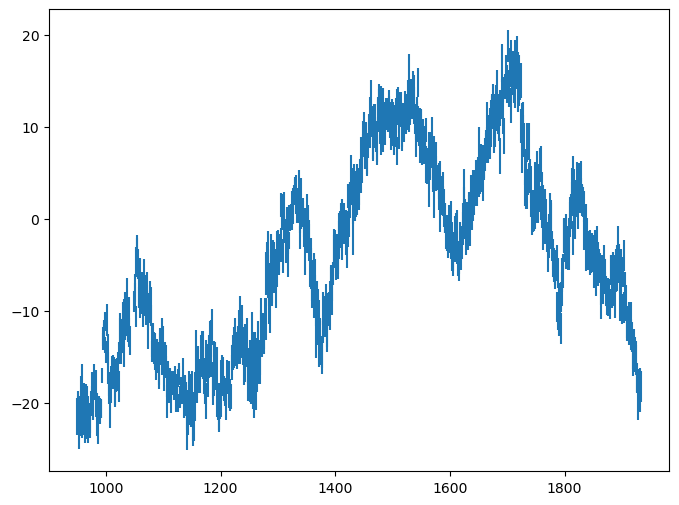

In [9]:
data = pd.read_csv("../data/brehm21_edit.csv")
plt.errorbar(data.year, data.d14c, yerr=data.sig_d14c, linestyle='None')

In [10]:
mask = ~((data.year >  992)  * (data.year < 1000))
newdata = pd.DataFrame({'year':data.year[mask],
            'd14c':data.d14c[mask],
           'sig_d14c':data.sig_d14c[mask]})
heavy_clipping=[3,8,35,36,42,50,51,52,53,57,92,97,98,99,100,120,186,201,219,229,298,301,305,322,323,325,347,356,406,460,467,469,502,
                      547,566,583,602,611,661,687,723,727,730,737,742,751,759,765,767,768,785,791,792,796,805,821,823,824,825,826,827,828,
                      829,848,849,898,927,937]
loose_clipping=[51,99,469,583,661,723,727,730,827]
newdata=newdata.drop(heavy_clipping)
pd.DataFrame.reset_index(newdata);

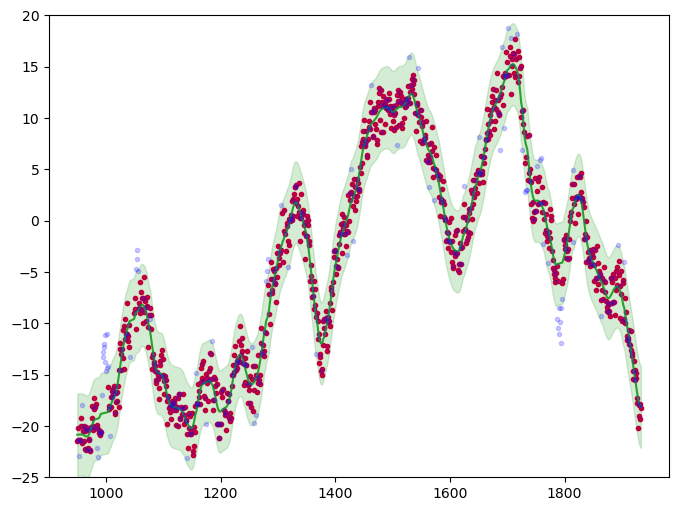

In [11]:
newgauss = gaussfilt(newdata.d14c,5)
plt.plot(newdata.year,newdata.d14c,'.',color='r')
plt.plot(newdata.year,newgauss,color='C2')
plt.fill_between(newdata.year,newgauss-4,newgauss+4,color='C2',alpha=0.2)
plt.ylim(-25,20)
plt.plot(data.year,data.d14c,'.',color='b',alpha=0.2)

In [12]:
#Resample a signal 512 times
def resample_signal(data_frame):
    resampler = resample.Resampler()
    resampler.load_data(data_frame.year, data_frame.d14c, data_frame.sig_d14c)
    resampler.annual = np.arange(np.ceil(resampler.start), np.floor(resampler.end + 1))
    new_signal = resampler.signal_resample(size=512)
    return(new_signal)
#Normalise and zero an entered signal
def norm_zero_signal(data_frame):
    new_signal=resample_signal(data_frame)
    zero_signal=new_signal.copy()
    zero_signal-=new_signal.mean(axis=1)[:,None]
    norm_signal=zero_signal/np.sqrt((zero_signal**2).sum(axis=1))[:,None]
    return(norm_signal)
#Find the covarience matrix from an entered signal
def covarience_matrix(signal):
    covmat = np.corrcoef(signal)
    return(covmat)
#Remove the diagonal entries in a matrix
def remove_diag(matrix):
    off_diag = matrix[~np.eye(matrix.shape[0],dtype=bool)]
    return(off_diag)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


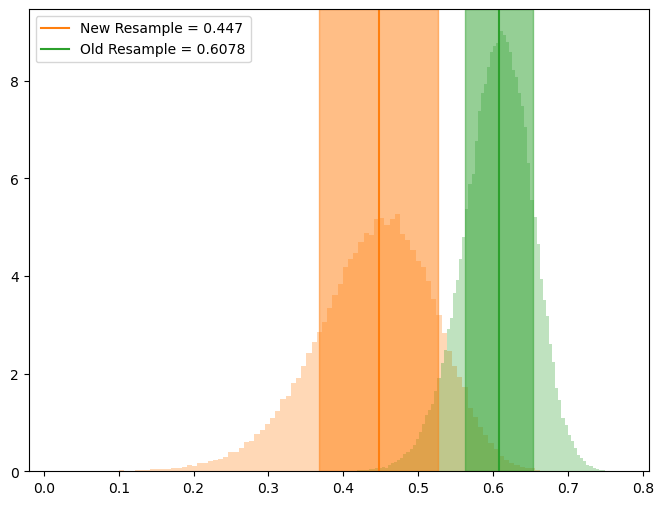

In [13]:
new_sig=norm_zero_signal(newdata)
old_sig=norm_zero_signal(data)
new_full_matrix=covarience_matrix(new_sig)
new_diagonal = remove_diag(new_full_matrix)
old_full_matrix=covarience_matrix(old_sig)
old_diagonal=remove_diag(old_full_matrix)
plt.hist(new_diagonal,bins=100,density=True,color='C1',alpha=0.3);
plt.hist(old_diagonal,bins=100,density=True,color='C2',alpha=0.3);
newm, news = np.nanmedian(new_diagonal), np.nanstd(new_diagonal)
oldm, olds = np.nanmedian(old_diagonal), np.nanstd(old_diagonal)
label1='New Resample = '+str(round(newm,4))
label2='Old Resample = '+str(round(oldm,4))
plt.axvline(newm,color='C1',label=label1)
plt.axvspan(newm-news,newm+news,color='C1',alpha=0.5)
plt.axvline(oldm,color='C2',label=label2)
plt.axvspan(oldm-olds,oldm+olds,color='C2',alpha=0.5)
plt.legend();